In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-2025-season-metadata/rbsdm.comstats.csv
/kaggle/input/nfl-2025-season-metadata/rbsdm.comstats (1).csv
/kaggle/input/nfl-2025-season-metadata/nfl-2024-UTC.csv
/kaggle/input/nfl-2025-season-metadata/rbsdm.comstats (2).csv
/kaggle/input/nfl-2025-season-metadata/nfl-2025-UTC.csv


In [42]:
ABBR_TO_ID = {
    "ARI": 0, "ATL": 1, "BAL": 2, "BUF": 3, "CAR": 4, "CHI": 5,
    "CIN": 6, "CLE": 7, "DAL": 8, "DEN": 9, "DET": 10, "GB": 11,
    "HOU": 12, "IND": 13, "JAX": 14, "KC": 15, "LV": 16, "LAC": 17,
    "LA": 18, "MIA": 19, "MIN": 20, "NE": 21, "NO": 22, "NYG": 23,
    "NYJ": 24, "PHI": 25, "PIT": 26, "SF": 27, "SEA": 28, "TB": 29,
    "TEN": 30, "WAS": 31,
}

In [43]:
TEAM_TO_ABBR = {
    "Arizona Cardinals": "ARI",
    "Atlanta Falcons": "ATL",
    "Baltimore Ravens": "BAL",
    "Buffalo Bills": "BUF",
    "Carolina Panthers": "CAR",
    "Chicago Bears": "CHI",
    "Cincinnati Bengals": "CIN",
    "Cleveland Browns": "CLE",
    "Dallas Cowboys": "DAL",
    "Denver Broncos": "DEN",
    "Detroit Lions": "DET",
    "Green Bay Packers": "GB",
    "Houston Texans": "HOU",
    "Indianapolis Colts": "IND",
    "Jacksonville Jaguars": "JAX",
    "Kansas City Chiefs": "KC",
    "Las Vegas Raiders": "LV",
    "Los Angeles Chargers": "LAC",
    "Los Angeles Rams": "LA",
    "Miami Dolphins": "MIA",
    "Minnesota Vikings": "MIN",
    "New England Patriots": "NE",
    "New Orleans Saints": "NO",
    "New York Giants": "NYG",
    "New York Jets": "NYJ",
    "Philadelphia Eagles": "PHI",
    "Pittsburgh Steelers": "PIT",
    "San Francisco 49ers": "SF",
    "Seattle Seahawks": "SEA",
    "Tampa Bay Buccaneers": "TB",
    "Tennessee Titans": "TEN",
    "Washington Commanders": "WAS",
}

In [44]:
PLAYER_TO_ABBR = {
    "D.Maye": "NE",
    "B.Purdy": "SF",
    "J.Love": "GB",
    "S.Darnold": "SEA",
    "M.Stafford": "LA",
    "D.Prescott": "DAL",
    "J.Allen": "BUF",
    "D.Jones": "IND",
    "J.Hurts": "PHI",
    "C.Stroud": "HOU",
    "L.Jackson": "BAL",
    "J.Goff": "DET",
    "J.Herbert": "LAC",
    "T.Shough": "NO",
    "P.Mahomes": "KC",
    "J.Dart": "NYG",
    "T.Lawrence": "JAX",
    "T.Tagovailoa": "MIA",
    "J.Brissett": "ARI",
    "M.Penix": "ATL",
    "B.Mayfield": "TB",
    "B.Nix": "DEN",
    "A.Rodgers": "PIT",
    "C.Williams": "CHI",
    "B.Young": "CAR",
    "J.Flacco": "CLE",
    "G.Smith": "LV",
    "C.Ward": "TEN",
}

In [45]:
import polars as pl
TwentyTwentyFour = pl.read_csv('/kaggle/input/nfl-2025-season-metadata/nfl-2024-UTC.csv',infer_schema=True,infer_schema_length=10000)
TwentyTwentyFive = pl.read_csv('/kaggle/input/nfl-2025-season-metadata/nfl-2025-UTC.csv',infer_schema=True,infer_schema_length=10000)

In [46]:
defensive_stats = pl.read_csv('/kaggle/input/nfl-2025-season-metadata/rbsdm.comstats (1).csv')
offensive_stats = pl.read_csv('/kaggle/input/nfl-2025-season-metadata/rbsdm.comstats.csv')
QB_stats = pl.read_csv('/kaggle/input/nfl-2025-season-metadata/rbsdm.comstats (2).csv')
QB_stats = QB_stats.with_columns(
    pl.col('Player').replace(PLAYER_TO_ABBR).alias('Abbr')
).drop('Team')

In [47]:
QB_stats

,Player,Plays,EPA+CPOE composite,Adj. EPA/play,EPA/play,Success rate,Cmp%,Expected cmp%,CPOE,Air yards,Abbr
i64,str,i64,f64,f64,f64,str,f64,f64,f64,f64,str
1,"""D.Maye""",562,0.213,0.305,0.294,"""55.3%""",74.3,64.3,10.0,9.3,"""NE"""
2,"""B.Purdy""",300,0.202,0.323,0.304,"""56.7%""",72.5,65.5,7.0,7.7,"""SF"""
3,"""J.Love""",494,0.196,0.317,0.312,"""52.8%""",71.9,65.7,6.2,8.9,"""GB"""
4,"""S.Darnold""",467,0.152,0.199,0.166,"""53.3%""",72.6,66.6,6.0,8.1,"""SEA"""
5,"""M.Stafford""",589,0.151,0.253,0.225,"""53.5%""",67.6,65.5,2.1,9.2,"""LA"""
…,…,…,…,…,…,…,…,…,…,…,…
25,"""C.Williams""",630,0.065,0.108,0.099,"""45.9%""",63.3,66.7,-3.4,8.3,"""CHI"""
26,"""B.Young""",489,0.053,0.024,-0.001,"""45.0%""",67.5,67.5,-0.1,6.6,"""CAR"""
27,"""J.Flacco""",403,0.025,-0.005,-0.044,"""42.2%""",64.4,67.6,-3.3,7.6,"""CLE"""


In [48]:
defensive_stats

,Team,Abbr,EPA/play,Success Rate (SR),Dropback EPA,Dropback SR,Rush EPA,Rush SR
i64,str,str,f64,str,f64,str,f64,str
1,"""""","""PHI""",-0.195,"""38.1%""",-0.253,"""37.5%""",-0.111,"""39.0%"""
2,"""""","""SEA""",-0.175,"""38.3%""",-0.148,"""39.9%""",-0.211,"""36.2%"""
3,"""""","""HOU""",-0.172,"""36.6%""",-0.162,"""38.4%""",-0.192,"""33.1%"""
4,"""""","""CLE""",-0.128,"""38.3%""",-0.298,"""35.6%""",0.081,"""41.5%"""
5,"""""","""LAC""",-0.125,"""41.9%""",-0.119,"""43.0%""",-0.134,"""40.3%"""
…,…,…,…,…,…,…,…,…
28,"""""","""TB""",0.137,"""47.1%""",0.225,"""50.6%""",-0.017,"""41.0%"""
29,"""""","""ARI""",0.155,"""49.4%""",0.207,"""52.6%""",0.079,"""44.8%"""
30,"""""","""NYJ""",0.176,"""49.0%""",0.28,"""52.1%""",0.023,"""44.4%"""


In [49]:
#TwentyTwentyFour

In [50]:
from sklearn.preprocessing import LabelEncoder
def smooth_season(season):
    encoder = LabelEncoder()
    season = season.with_columns(
        pl.col("Date").str.to_datetime("%d/%m/%Y %H:%M")
    ).with_columns(
        pl.col("Result").str.extract(r"(\d+)\s*-\s*(\d+)", 1).cast(pl.Int64).alias("Home Score"),
        pl.col("Result").str.extract(r"(\d+)\s*-\s*(\d+)", 2).cast(pl.Int64).alias("Away Score"),
        pl.col("Date").dt.day().alias("Day"),
        pl.col("Date").dt.hour().alias("Hour"),
        pl.col("Location").map_batches(encoder.fit_transform).alias("NumericLocation"),
        pl.col("Home Team").replace(TEAM_TO_ABBR).alias("Home"),
        pl.col("Away Team").replace(TEAM_TO_ABBR).alias("Away"),
    ).drop("Date", "Home Team", "Away Team","Location")
    return season

In [51]:
TwentyTwentyFour = smooth_season(TwentyTwentyFour)

TwentyTwentyFive = smooth_season(TwentyTwentyFive)

In [52]:
#TwentyTwentyFive

In [53]:
TwentyTwentyFour = TwentyTwentyFour.drop('Result')

In [54]:
playoffs = TwentyTwentyFive.filter(pl.col('Result').is_null() )
TwentyTwentyFive = TwentyTwentyFive.filter(pl.col('Result').is_not_null())
TwentyTwentyFive = TwentyTwentyFive.with_columns(
    pl.col('Round Number').cast(pl.Int32).alias('Round Number')
).drop('Result')
TwentyTwentyFive = TwentyTwentyFive.filter(pl.col('Round Number') > 9)
TwentyTwentyFive = TwentyTwentyFive.filter(pl.col('Round Number').ne(18))
TwentyTwentyFive

Match Number,Round Number,Home Score,Away Score,Day,Hour,NumericLocation,Home,Away
i64,i32,i64,i64,i8,i8,i64,str,str
136,10,10,7,7,1,7,"""DEN""","""LV"""
137,10,31,25,9,14,26,"""IND""","""ATL"""
138,10,7,17,9,18,4,"""CAR""","""NO"""
139,10,24,20,9,18,31,"""CHI""","""NYG"""
140,10,36,29,9,18,23,"""HOU""","""JAX"""
…,…,…,…,…,…,…,…,…
253,17,37,14,28,18,27,"""CIN""","""ARI"""
256,17,10,34,28,21,2,"""LV""","""NYG"""
249,17,12,13,28,21,13,"""BUF""","""PHI"""


In [55]:
#playoffs

In [56]:
class team:
    def __init__(self, name, QB, defence, offence, elo=100):
        self.name = name
        self.elo = elo
        self.QB = QB
        self.defence = defence
        self.offence = offence
        
    def set_elo(self,new_elo):
        self.elo = new_elo
        return

In [57]:
def make_teams(TEAM_TO_ABBR,defensive_stats,offensive_stats,QB_stats):
    teams = []
    for teamName in TEAM_TO_ABBR.values():
        defence = defensive_stats.filter(pl.col('Abbr').eq(teamName))
        offence = offensive_stats.filter(pl.col('Abbr').eq(teamName))
        qb = QB_stats.filter(pl.col('Abbr').eq(teamName))
        teams.append(team(teamName,qb,defence,offence))
    return teams

In [58]:
def seed_teams(season,teams):
    for column in season.rows():
        #6 Home, 7 away
        home_id = ABBR_TO_ID[column[7]]
        away_id = ABBR_TO_ID[column[8]]
        
        if(column[2] > column[3]):
            if teams[home_id].elo > teams[away_id].elo:
                teams[home_id].set_elo((teams[home_id].elo + (teams[away_id].elo * 0.1)))
                teams[away_id].set_elo(teams[away_id].elo * 0.9)
            else:
                teams[home_id].set_elo((teams[home_id].elo + (teams[away_id].elo * 0.15)))
                teams[away_id].set_elo(teams[away_id].elo * 0.85)
                
        if(column[3] > column[2]):
            #print('hoozits')
            if teams[home_id].elo > teams[away_id].elo:
                teams[away_id].set_elo((teams[away_id].elo + (teams[home_id].elo * 0.2)))
                teams[home_id].set_elo(teams[home_id].elo * 0.8)
                #upset value
            else:
                teams[away_id].set_elo((teams[away_id].elo + (teams[home_id].elo * 0.125)))
                teams[home_id].set_elo(teams[home_id].elo * 0.875)
        
    return season

In [59]:
def play_season(season, teams):
    home_elos = []
    away_elos = []
    defensive_epa_home = []
    defensive_epa_away = []
    offensive_epa_home = []
    offensive_epa_away = []
    SR_defensive_home = []
    SR_defensive_away = []
    SR_offensive_home = []
    SR_offensive_away = []
    drop_defensive_home = []
    drop_defensive_away = []
    drop_offensive_home = []
    drop_offensive_away = []

    dropSR_defensive_home = []
    dropSR_defensive_away = []
    dropSR_offensive_home = []
    dropSR_offensive_away = []
    defensive_Rush_epa_home = []
    defensive_Rush_epa_away = []
    offensive_Rush_epa_home = []
    offensive_Rush_epa_away = []
    defensive_Rush_SR_home = []
    defensive_Rush_SR_away = []
    offensive_Rush_SR_home = []
    offensive_Rush_SR_away = []

    #Team	Abbr	EPA/play	Success Rate (SR)	Dropback EPA	Dropback SR	Rush EPA	Rush SR
    
    for row in season.rows():
        home_id = ABBR_TO_ID[row[7]]
        away_id = ABBR_TO_ID[row[8]]
        
        home_elos.append(teams[home_id].elo)
        away_elos.append(teams[away_id].elo)
        # Offensive stats
        offensive_epa_home.append(teams[home_id].offence["EPA/play"][0])
        offensive_epa_away.append(teams[away_id].offence["EPA/play"][0])
        SR_offensive_home.append(teams[home_id].offence["Success Rate (SR)"][0])
        SR_offensive_away.append(teams[away_id].offence["Success Rate (SR)"][0])
        drop_offensive_home.append(teams[home_id].offence["Dropback EPA"][0])
        drop_offensive_away.append(teams[away_id].offence["Dropback EPA"][0])
        dropSR_offensive_home.append(teams[home_id].offence["Dropback SR"][0])
        dropSR_offensive_away.append(teams[away_id].offence["Dropback SR"][0])
        offensive_Rush_epa_home.append(teams[home_id].offence["Rush EPA"][0])
        offensive_Rush_epa_away.append(teams[away_id].offence["Rush EPA"][0])
        offensive_Rush_SR_home.append(teams[home_id].offence["Rush SR"][0])
        offensive_Rush_SR_away.append(teams[away_id].offence["Rush SR"][0])
        
        # Defensive stats
        defensive_epa_home.append(teams[home_id].defence["EPA/play"][0])
        defensive_epa_away.append(teams[away_id].defence["EPA/play"][0])
        SR_defensive_home.append(teams[home_id].defence["Success Rate (SR)"][0])
        SR_defensive_away.append(teams[away_id].defence["Success Rate (SR)"][0])
        drop_defensive_home.append(teams[home_id].defence["Dropback EPA"][0])
        drop_defensive_away.append(teams[away_id].defence["Dropback EPA"][0])
        dropSR_defensive_home.append(teams[home_id].defence["Dropback SR"][0])
        dropSR_defensive_away.append(teams[away_id].defence["Dropback SR"][0])
        defensive_Rush_epa_home.append(teams[home_id].defence["Rush EPA"][0])
        defensive_Rush_epa_away.append(teams[away_id].defence["Rush EPA"][0])
        defensive_Rush_SR_home.append(teams[home_id].defence["Rush SR"][0])
        defensive_Rush_SR_away.append(teams[away_id].defence["Rush SR"][0])

        
        
        if row[2] > row[3]:
            if teams[home_id].elo > teams[away_id].elo:
                teams[home_id].set_elo(teams[home_id].elo + (teams[away_id].elo * 0.2))
                teams[away_id].set_elo(teams[away_id].elo * 0.8)
            else:
                teams[home_id].set_elo(teams[home_id].elo + (teams[away_id].elo * 0.30))
                teams[away_id].set_elo(teams[away_id].elo * 0.7)
                
        elif row[3] > row[2]:
            if teams[home_id].elo > teams[away_id].elo:
                teams[away_id].set_elo(teams[away_id].elo + (teams[home_id].elo * 0.4))
                teams[home_id].set_elo(teams[home_id].elo * 0.6)
            else:
                teams[away_id].set_elo(teams[away_id].elo + (teams[home_id].elo * 0.25))
                teams[home_id].set_elo(teams[home_id].elo * 0.75)
    
    season = season.with_columns(
        pl.Series("Home_Elo", home_elos),
        pl.Series("Away_Elo", away_elos),
        pl.Series("Home_Off_EPA", offensive_epa_home),
        pl.Series("Away_Off_EPA", offensive_epa_away),
        pl.Series("Home_Off_SR", SR_offensive_home),
        pl.Series("Away_Off_SR", SR_offensive_away),
        pl.Series("Home_Off_Drop_EPA", drop_offensive_home),
        pl.Series("Away_Off_Drop_EPA", drop_offensive_away),
        pl.Series("Home_Off_Drop_SR", dropSR_offensive_home),
        pl.Series("Away_Off_Drop_SR", dropSR_offensive_away),
        pl.Series("Home_Off_Rush_EPA", offensive_Rush_epa_home),
        pl.Series("Away_Off_Rush_EPA", offensive_Rush_epa_away),
        pl.Series("Home_Off_Rush_SR", offensive_Rush_SR_home),
        pl.Series("Away_Off_Rush_SR", offensive_Rush_SR_away),
        pl.Series("Home_Def_EPA", defensive_epa_home),
        pl.Series("Away_Def_EPA", defensive_epa_away),
        pl.Series("Home_Def_SR", SR_defensive_home),
        pl.Series("Away_Def_SR", SR_defensive_away),
        pl.Series("Home_Def_Drop_EPA", drop_defensive_home),
        pl.Series("Away_Def_Drop_EPA", drop_defensive_away),
        pl.Series("Home_Def_Drop_SR", dropSR_defensive_home),
        pl.Series("Away_Def_Drop_SR", dropSR_defensive_away),
        pl.Series("Home_Def_Rush_EPA", defensive_Rush_epa_home),
        pl.Series("Away_Def_Rush_EPA", defensive_Rush_epa_away),
        pl.Series("Home_Def_Rush_SR", defensive_Rush_SR_home),
        pl.Series("Away_Def_Rush_SR", defensive_Rush_SR_away),
    )
    
    return season

In [60]:
def post_season(season, teams):
    home_elos = []
    away_elos = []
    defensive_epa_home = []
    defensive_epa_away = []
    offensive_epa_home = []
    offensive_epa_away = []
    SR_defensive_home = []
    SR_defensive_away = []
    SR_offensive_home = []
    SR_offensive_away = []
    drop_defensive_home = []
    drop_defensive_away = []
    drop_offensive_home = []
    drop_offensive_away = []

    dropSR_defensive_home = []
    dropSR_defensive_away = []
    dropSR_offensive_home = []
    dropSR_offensive_away = []
    defensive_Rush_epa_home = []
    defensive_Rush_epa_away = []
    offensive_Rush_epa_home = []
    offensive_Rush_epa_away = []
    defensive_Rush_SR_home = []
    defensive_Rush_SR_away = []
    offensive_Rush_SR_home = []
    offensive_Rush_SR_away = []

    #Team	Abbr	EPA/play	Success Rate (SR)	Dropback EPA	Dropback SR	Rush EPA	Rush SR
    
    for row in season.rows():
        home_id = ABBR_TO_ID[row[8]]
        away_id = ABBR_TO_ID[row[9]]
        
        home_elos.append(teams[home_id].elo)
        away_elos.append(teams[away_id].elo)
        # Offensive stats
        offensive_epa_home.append(teams[home_id].offence["EPA/play"][0])
        offensive_epa_away.append(teams[away_id].offence["EPA/play"][0])
        SR_offensive_home.append(teams[home_id].offence["Success Rate (SR)"][0])
        SR_offensive_away.append(teams[away_id].offence["Success Rate (SR)"][0])
        drop_offensive_home.append(teams[home_id].offence["Dropback EPA"][0])
        drop_offensive_away.append(teams[away_id].offence["Dropback EPA"][0])
        dropSR_offensive_home.append(teams[home_id].offence["Dropback SR"][0])
        dropSR_offensive_away.append(teams[away_id].offence["Dropback SR"][0])
        offensive_Rush_epa_home.append(teams[home_id].offence["Rush EPA"][0])
        offensive_Rush_epa_away.append(teams[away_id].offence["Rush EPA"][0])
        offensive_Rush_SR_home.append(teams[home_id].offence["Rush SR"][0])
        offensive_Rush_SR_away.append(teams[away_id].offence["Rush SR"][0])
        
        # Defensive stats
        defensive_epa_home.append(teams[home_id].defence["EPA/play"][0])
        defensive_epa_away.append(teams[away_id].defence["EPA/play"][0])
        SR_defensive_home.append(teams[home_id].defence["Success Rate (SR)"][0])
        SR_defensive_away.append(teams[away_id].defence["Success Rate (SR)"][0])
        drop_defensive_home.append(teams[home_id].defence["Dropback EPA"][0])
        drop_defensive_away.append(teams[away_id].defence["Dropback EPA"][0])
        dropSR_defensive_home.append(teams[home_id].defence["Dropback SR"][0])
        dropSR_defensive_away.append(teams[away_id].defence["Dropback SR"][0])
        defensive_Rush_epa_home.append(teams[home_id].defence["Rush EPA"][0])
        defensive_Rush_epa_away.append(teams[away_id].defence["Rush EPA"][0])
        defensive_Rush_SR_home.append(teams[home_id].defence["Rush SR"][0])
        defensive_Rush_SR_away.append(teams[away_id].defence["Rush SR"][0])
    
    season = season.with_columns(
        pl.Series("Home_Elo", home_elos),
        pl.Series("Away_Elo", away_elos),
        pl.Series("Home_Off_EPA", offensive_epa_home),
        pl.Series("Away_Off_EPA", offensive_epa_away),
        pl.Series("Home_Off_SR", SR_offensive_home),
        pl.Series("Away_Off_SR", SR_offensive_away),
        pl.Series("Home_Off_Drop_EPA", drop_offensive_home),
        pl.Series("Away_Off_Drop_EPA", drop_offensive_away),
        pl.Series("Home_Off_Drop_SR", dropSR_offensive_home),
        pl.Series("Away_Off_Drop_SR", dropSR_offensive_away),
        pl.Series("Home_Off_Rush_EPA", offensive_Rush_epa_home),
        pl.Series("Away_Off_Rush_EPA", offensive_Rush_epa_away),
        pl.Series("Home_Off_Rush_SR", offensive_Rush_SR_home),
        pl.Series("Away_Off_Rush_SR", offensive_Rush_SR_away),
        pl.Series("Home_Def_EPA", defensive_epa_home),
        pl.Series("Away_Def_EPA", defensive_epa_away),
        pl.Series("Home_Def_SR", SR_defensive_home),
        pl.Series("Away_Def_SR", SR_defensive_away),
        pl.Series("Home_Def_Drop_EPA", drop_defensive_home),
        pl.Series("Away_Def_Drop_EPA", drop_defensive_away),
        pl.Series("Home_Def_Drop_SR", dropSR_defensive_home),
        pl.Series("Away_Def_Drop_SR", dropSR_defensive_away),
        pl.Series("Home_Def_Rush_EPA", defensive_Rush_epa_home),
        pl.Series("Away_Def_Rush_EPA", defensive_Rush_epa_away),
        pl.Series("Home_Def_Rush_SR", defensive_Rush_SR_home),
        pl.Series("Away_Def_Rush_SR", defensive_Rush_SR_away),
    )
    
    return season

In [61]:
teams = make_teams(TEAM_TO_ABBR,defensive_stats,offensive_stats,QB_stats)
seed_teams(TwentyTwentyFour,teams)
TwentyTwentyFive = play_season(TwentyTwentyFive,teams)
TwentyTwentyFive

Match Number,Round Number,Home Score,Away Score,Day,Hour,NumericLocation,Home,Away,Home_Elo,Away_Elo,Home_Off_EPA,Away_Off_EPA,Home_Off_SR,Away_Off_SR,Home_Off_Drop_EPA,Away_Off_Drop_EPA,Home_Off_Drop_SR,Away_Off_Drop_SR,Home_Off_Rush_EPA,Away_Off_Rush_EPA,Home_Off_Rush_SR,Away_Off_Rush_SR,Home_Def_EPA,Away_Def_EPA,Home_Def_SR,Away_Def_SR,Home_Def_Drop_EPA,Away_Def_Drop_EPA,Home_Def_Drop_SR,Away_Def_Drop_SR,Home_Def_Rush_EPA,Away_Def_Rush_EPA,Home_Def_Rush_SR,Away_Def_Rush_SR
i64,i32,i64,i64,i8,i8,i64,str,str,f64,f64,f64,f64,str,str,f64,f64,str,str,f64,f64,str,str,f64,f64,str,str,f64,f64,str,str,f64,f64,str,str
136,10,10,7,7,1,7,"""DEN""","""LV""",118.062205,37.707844,0.058,-0.252,"""45.7%""","""36.0%""",0.139,-0.236,"""46.6%""","""39.8%""",-0.089,-0.284,"""44.0%""","""28.3%""",-0.027,0.023,"""38.2%""","""44.8%""",0.014,0.029,"""39.3%""","""44.9%""",-0.115,0.016,"""35.8%""","""44.8%"""
137,10,31,25,9,14,26,"""IND""","""ATL""",72.123108,59.0423,-0.014,0.068,"""43.2%""","""45.7%""",-0.011,0.107,"""42.9%""","""47.8%""",-0.019,0.02,"""43.7%""","""43.0%""",0.076,0.029,"""47.1%""","""44.9%""",0.175,0.055,"""49.3%""","""46.4%""",-0.08,-0.014,"""43.7%""","""42.6%"""
138,10,7,17,9,18,4,"""CAR""","""NO""",60.344454,38.586768,-0.023,-0.02,"""41.1%""","""41.2%""",0.059,0.065,"""43.6%""","""45.4%""",-0.132,-0.149,"""37.9%""","""34.8%""",0.058,-0.073,"""47.9%""","""40.7%""",0.091,-0.035,"""48.5%""","""41.4%""",0.015,-0.122,"""47.1%""","""39.8%"""
139,10,24,20,9,18,31,"""CHI""","""NYG""",61.43748,34.732636,0.146,0.038,"""50.0%""","""41.0%""",0.183,0.097,"""46.9%""","""42.9%""",0.094,-0.038,"""54.4%""","""38.6%""",0.052,0.107,"""45.9%""","""47.1%""",0.09,0.073,"""47.4%""","""48.0%""",0.001,0.157,"""43.9%""","""45.7%"""
140,10,36,29,9,18,23,"""HOU""","""JAX""",88.265721,38.152701,-0.036,0.092,"""40.3%""","""47.7%""",0.053,0.129,"""42.2%""","""50.6%""",-0.179,0.033,"""37.1%""","""43.1%""",-0.172,-0.057,"""36.6%""","""44.1%""",-0.162,-0.016,"""38.4%""","""47.0%""",-0.192,-0.141,"""33.1%""","""38.1%"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
253,17,37,14,28,18,27,"""CIN""","""ARI""",121.056839,9.713818,0.053,-0.028,"""45.9%""","""44.7%""",0.061,0.038,"""45.9%""","""47.3%""",0.038,-0.173,"""45.8%""","""39.1%""",0.137,0.155,"""47.8%""","""49.4%""",0.244,0.207,"""51.8%""","""52.6%""",-0.03,0.079,"""41.4%""","""44.8%"""
256,17,10,34,28,21,2,"""LV""","""NYG""",6.515915,7.502249,-0.252,0.038,"""36.0%""","""41.0%""",-0.236,0.097,"""39.8%""","""42.9%""",-0.284,-0.038,"""28.3%""","""38.6%""",0.023,0.107,"""44.8%""","""47.1%""",0.029,0.073,"""44.9%""","""48.0%""",0.016,0.157,"""44.8%""","""45.7%"""
249,17,12,13,28,21,13,"""BUF""","""PHI""",205.726479,114.266608,0.061,-0.011,"""46.7%""","""41.6%""",0.078,0.059,"""47.2%""","""44.8%""",0.036,-0.117,"""45.9%""","""36.7%""",0.004,-0.195,"""45.6%""","""38.1%""",-0.07,-0.253,"""44.2%""","""37.5%""",0.1,-0.111,"""47.3%""","""39.0%"""


In [62]:
rolling_elo = 0
for i in range(32):
    rolling_elo = teams[i].elo + rolling_elo
    print('Team name: ',teams[i].name,' Team Elo:', teams[i].elo)
print('Rolling Elo', rolling_elo)

Team name:  ARI  Team Elo: 7.771054437320903
Team name:  ATL  Team Elo: 77.8680699581248
Team name:  BAL  Team Elo: 124.12990904598098
Team name:  BUF  Team Elo: 123.43588741622132
Team name:  CAR  Team Elo: 56.07777420416624
Team name:  CHI  Team Elo: 151.66686887993654
Team name:  CIN  Team Elo: 122.99960222591686
Team name:  CLE  Team Elo: 70.64869440591676
Team name:  DAL  Team Elo: 76.9899292564285
Team name:  DEN  Team Elo: 187.87654474722927
Team name:  DET  Team Elo: 75.64663023038996
Team name:  GB  Team Elo: 73.63723260632045
Team name:  HOU  Team Elo: 243.74994148215382
Team name:  IND  Team Elo: 18.129218638658525
Team name:  JAX  Team Elo: 219.61958467728877
Team name:  KC  Team Elo: 38.822831143256565
Team name:  LV  Team Elo: 4.8869365622578025
Team name:  LAC  Team Elo: 129.72054466915287
Team name:  LA  Team Elo: 95.17157774000327
Team name:  MIA  Team Elo: 85.33799064300949
Team name:  MIN  Team Elo: 147.54581073414658
Team name:  NE  Team Elo: 162.88750605955576
Team

In [63]:
from sklearn.preprocessing import LabelEncoder
def season_encoder(season):
    # Columns to encode
    string_cols = [
        "Home", "Away",
        "Home_Off_SR", "Away_Off_SR",
        "Home_Off_Drop_SR", "Away_Off_Drop_SR",
        "Home_Off_Rush_SR", "Away_Off_Rush_SR",
        "Home_Def_SR", "Away_Def_SR",
        "Home_Def_Drop_SR", "Away_Def_Drop_SR",
        "Home_Def_Rush_SR", "Away_Def_Rush_SR"
    ]
    
    for col in string_cols:
        le = LabelEncoder()
        season = season.with_columns(
            pl.Series(col, le.fit_transform(season[col].to_list()))
        )
    return season

In [64]:
playoffs.drop("Result")

Match Number,Round Number,Home Score,Away Score,Day,Hour,NumericLocation,Home,Away
i64,str,i64,i64,i8,i8,i64,str,str
273,"""Wild Card Round""",null,null,10,21,4,"""CAR""","""LA"""
274,"""Wild Card Round""",null,null,11,1,31,"""CHI""","""GB"""
275,"""Wild Card Round""",null,null,11,18,8,"""JAX""","""BUF"""
276,"""Wild Card Round""",null,null,11,21,17,"""PHI""","""SF"""
277,"""Wild Card Round""",null,null,12,1,11,"""NE""","""LAC"""
278,"""Wild Card Round""",null,null,13,1,1,"""PIT""","""HOU"""


In [65]:
TwentyTwentyFive = season_encoder(TwentyTwentyFive)
TwentyTwentyFive = TwentyTwentyFive.drop("Match Number").drop("Round Number")
playoffs = post_season(playoffs,teams)
playoffs = season_encoder(playoffs)
playoffs = playoffs.drop("Match Number").drop("Round Number").drop("Result")

In [66]:
playoffs = playoffs.with_columns(
    pl.col("Home").replace({0: 4, 1: 5, 2: 14, 3: 21, 4: 25, 5: 26}).cast(pl.Int32),
    pl.col("Away").replace({3: 18, 1: 11, 0: 3, 5: 27, 4: 17, 2: 12}).cast(pl.Int32),
)
playoffs.describe()
#TwentyTwentyFive.describe()

statistic,Home Score,Away Score,Day,Hour,NumericLocation,Home,Away,Home_Elo,Away_Elo,Home_Off_EPA,Away_Off_EPA,Home_Off_SR,Away_Off_SR,Home_Off_Drop_EPA,Away_Off_Drop_EPA,Home_Off_Drop_SR,Away_Off_Drop_SR,Home_Off_Rush_EPA,Away_Off_Rush_EPA,Home_Off_Rush_SR,Away_Off_Rush_SR,Home_Def_EPA,Away_Def_EPA,Home_Def_SR,Away_Def_SR,Home_Def_Drop_EPA,Away_Def_Drop_EPA,Home_Def_Drop_SR,Away_Def_Drop_SR,Home_Def_Rush_EPA,Away_Def_Rush_EPA,Home_Def_Rush_SR,Away_Def_Rush_SR
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",0.0,0.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
"""null_count""",6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,11.333333,10.5,12.0,15.833333,14.666667,155.458685,136.80896,0.068167,0.0975,2.5,2.5,0.1115,0.1695,2.5,2.5,0.002167,-0.01,2.5,2.5,-0.033,-0.012833,2.5,2.5,-0.0385,0.021167,2.5,2.5,-0.027833,-0.055833,2.5,2.5
"""std""",null,null,1.032796,10.464225,10.844353,9.745084,8.066391,56.289225,59.541199,0.096618,0.114993,1.870829,1.870829,0.129336,0.136298,1.870829,1.870829,0.101846,0.136587,1.870829,1.870829,0.095474,0.117416,1.870829,1.870829,0.131968,0.171083,1.870829,1.870829,0.078959,0.100249,1.870829,1.870829
"""min""",null,null,10.0,1.0,1.0,4.0,3.0,56.077774,73.637233,-0.023,-0.036,0.0,0.0,-0.071,0.018,0.0,0.0,-0.132,-0.179,0.0,0.0,-0.195,-0.172,0.0,0.0,-0.253,-0.162,0.0,0.0,-0.141,-0.192,0.0,0.0
"""25%""",null,null,11.0,1.0,4.0,5.0,11.0,145.943179,95.171578,-0.011,-0.02,1.0,1.0,0.059,0.053,1.0,1.0,-0.117,-0.109,1.0,1.0,-0.068,-0.125,1.0,1.0,-0.122,-0.119,1.0,1.0,-0.111,-0.134,1.0,1.0
"""50%""",null,null,11.0,18.0,11.0,21.0,17.0,162.887506,129.720545,0.092,0.133,3.0,3.0,0.129,0.235,3.0,3.0,0.038,0.036,3.0,3.0,0.012,0.004,3.0,3.0,-0.016,0.027,3.0,3.0,0.012,-0.032,3.0,3.0
"""75%""",null,null,12.0,21.0,17.0,25.0,18.0,196.5572,155.138577,0.146,0.215,4.0,4.0,0.183,0.301,4.0,4.0,0.094,0.093,4.0,4.0,0.052,0.108,4.0,4.0,0.09,0.2,4.0,4.0,0.015,-0.03,4.0,4.0
"""max""",null,null,13.0,21.0,31.0,26.0,27.0,219.619585,243.749941,0.21,0.232,5.0,5.0,0.31,0.332,5.0,5.0,0.097,0.182,5.0,5.0,0.058,0.114,5.0,5.0,0.091,0.251,5.0,5.0,0.057,0.1,5.0,5.0


In [67]:
teams[20].defence

,Team,Abbr,EPA/play,Success Rate (SR),Dropback EPA,Dropback SR,Rush EPA,Rush SR
i64,str,str,f64,str,f64,str,f64,str
6,"""""","""MIN""",-0.106,"""40.5%""",-0.098,"""38.6%""",-0.114,"""42.5%"""


In [68]:
teams[20].offence

,Team,Abbr,EPA/play,Success Rate (SR),Dropback EPA,Dropback SR,Rush EPA,Rush SR
i64,str,str,f64,str,f64,str,f64,str
28,"""""","""MIN""",-0.094,"""43.1%""",-0.179,"""41.2%""",0.024,"""45.9%"""


In [69]:
X_home = TwentyTwentyFive.drop("Home Score")
y_home = TwentyTwentyFive["Home Score"]
X_away = TwentyTwentyFive.drop("Away Score")
y_away = TwentyTwentyFive["Away Score"]

In [70]:
from xgboost import XGBRegressor

bstHome = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42
)
bstAway = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42
)

X_home = TwentyTwentyFive.drop("Home Score", "Away Score").to_pandas()
y_home = TwentyTwentyFive["Home Score"].to_numpy()

X_away = TwentyTwentyFive.drop("Home Score", "Away Score").to_pandas()
y_away = TwentyTwentyFive["Away Score"].to_numpy()

bstHome.fit(X_home, y_home)
bstAway.fit(X_away, y_away)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [71]:
# Predict scores on playoffs
playoffs_X = playoffs.drop("Home Score", "Away Score").to_pandas()

playoffs = playoffs.with_columns(
    pl.Series("Predicted_Home_Score", bstHome.predict(playoffs_X)),
    pl.Series("Predicted_Away_Score", bstAway.predict(playoffs_X)),
)

# Add predicted winner
playoffs = playoffs.with_columns(
    pl.when(pl.col("Predicted_Home_Score") > pl.col("Predicted_Away_Score"))
    .then(pl.col("Home"))
    .otherwise(pl.col("Away"))
    .alias("Predicted_Winner")
)

playoffs

Home Score,Away Score,Day,Hour,NumericLocation,Home,Away,Home_Elo,Away_Elo,Home_Off_EPA,Away_Off_EPA,Home_Off_SR,Away_Off_SR,Home_Off_Drop_EPA,Away_Off_Drop_EPA,Home_Off_Drop_SR,Away_Off_Drop_SR,Home_Off_Rush_EPA,Away_Off_Rush_EPA,Home_Off_Rush_SR,Away_Off_Rush_SR,Home_Def_EPA,Away_Def_EPA,Home_Def_SR,Away_Def_SR,Home_Def_Drop_EPA,Away_Def_Drop_EPA,Home_Def_Drop_SR,Away_Def_Drop_SR,Home_Def_Rush_EPA,Away_Def_Rush_EPA,Home_Def_Rush_SR,Away_Def_Rush_SR,Predicted_Home_Score,Predicted_Away_Score,Predicted_Winner
i64,i64,i8,i8,i64,i32,i32,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,f32,f32,i32
null,null,10,21,4,4,18,56.077774,95.171578,-0.023,0.215,0,5,0.059,0.235,1,5,-0.132,0.182,1,5,0.058,-0.006,5,1,0.091,0.027,5,3,0.015,-0.047,4,1,18.387342,25.097233,18
null,null,11,1,31,5,11,151.666869,73.637233,0.146,0.133,5,3,0.183,0.301,3,3,0.094,-0.109,5,2,0.052,0.108,4,4,0.09,0.251,4,5,0.001,-0.03,3,3,27.601318,22.142559,5
null,null,11,18,8,14,3,219.619585,123.435887,0.092,0.061,3,2,0.129,0.078,4,2,0.033,0.036,3,3,-0.057,0.004,2,3,-0.016,-0.07,3,2,-0.141,0.1,0,4,21.746502,21.197672,14
null,null,11,21,17,25,27,196.5572,155.138577,-0.011,0.232,1,4,0.059,0.332,2,4,-0.117,0.093,0,4,-0.195,0.114,0,5,-0.253,0.2,0,4,-0.111,-0.032,1,5,25.50701,22.234486,25
null,null,12,1,11,21,17,162.887506,129.720545,0.21,-0.02,4,1,0.31,0.018,5,1,0.038,-0.083,2,1,0.012,-0.125,3,2,-0.021,-0.119,2,1,0.057,-0.134,5,2,18.654779,15.510896,21
null,null,13,1,1,26,12,145.943179,243.749941,-0.005,-0.036,2,0,-0.071,0.053,0,0,0.097,-0.179,4,0,-0.068,-0.172,1,0,-0.122,-0.162,1,0,0.012,-0.192,2,0,17.022503,15.766482,26


In [72]:
teams[26].defence

,Team,Abbr,EPA/play,Success Rate (SR),Dropback EPA,Dropback SR,Rush EPA,Rush SR
i64,str,str,f64,str,f64,str,f64,str
8,"""""","""PIT""",-0.068,"""40.7%""",-0.122,"""40.1%""",0.012,"""41.7%"""


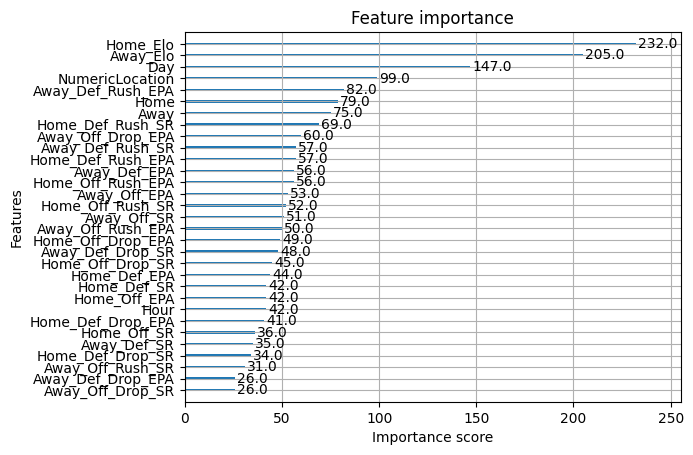

In [73]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(bstHome.get_booster())
plt.show()

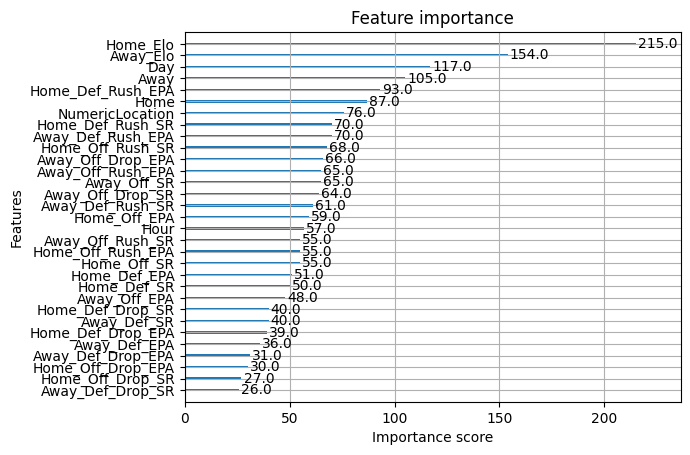

In [74]:
plot_importance(bstAway.get_booster())
plt.show()